# 3 Transformer Language Model Architecture

这是一种语言模型以一批整数标记 ID 序列（即形状为（batch_size，sequence_length）的 torch.Tensor）作为输入，并返回一个（批量的）词汇表上的归一化概率分布（即形状为（batch_size，sequence_length，vocab_size）的 PyTorch Tensor），其中预测的分布是针对每个输入标记的下一个词。在训练语言模型时，我们使用这些下一个词的预测来计算实际下一个词和预测下一个词之间的交叉熵损失。在推理期间从语言模型生成文本时，我们取最终时间步的预测下一个词分布（即序列中的最后一个项）来生成序列中的下一个标记（例如，通过选择概率最高的标记、从分布中采样等），将生成的标记添加到输入序列中，并重复此过程。

## 3.1 Transformer LM

给定一系列标记 ID，Transformer 语言模型使用输入嵌入将标记 ID 转换为密集向量，将嵌入的标记通过 num_layers 个 Transformer 块，然后应用一个学习的线性投影（即“输出嵌入”或“LM 头”）来生成预测的下一个标记 logits。参见图 1 的示意图。

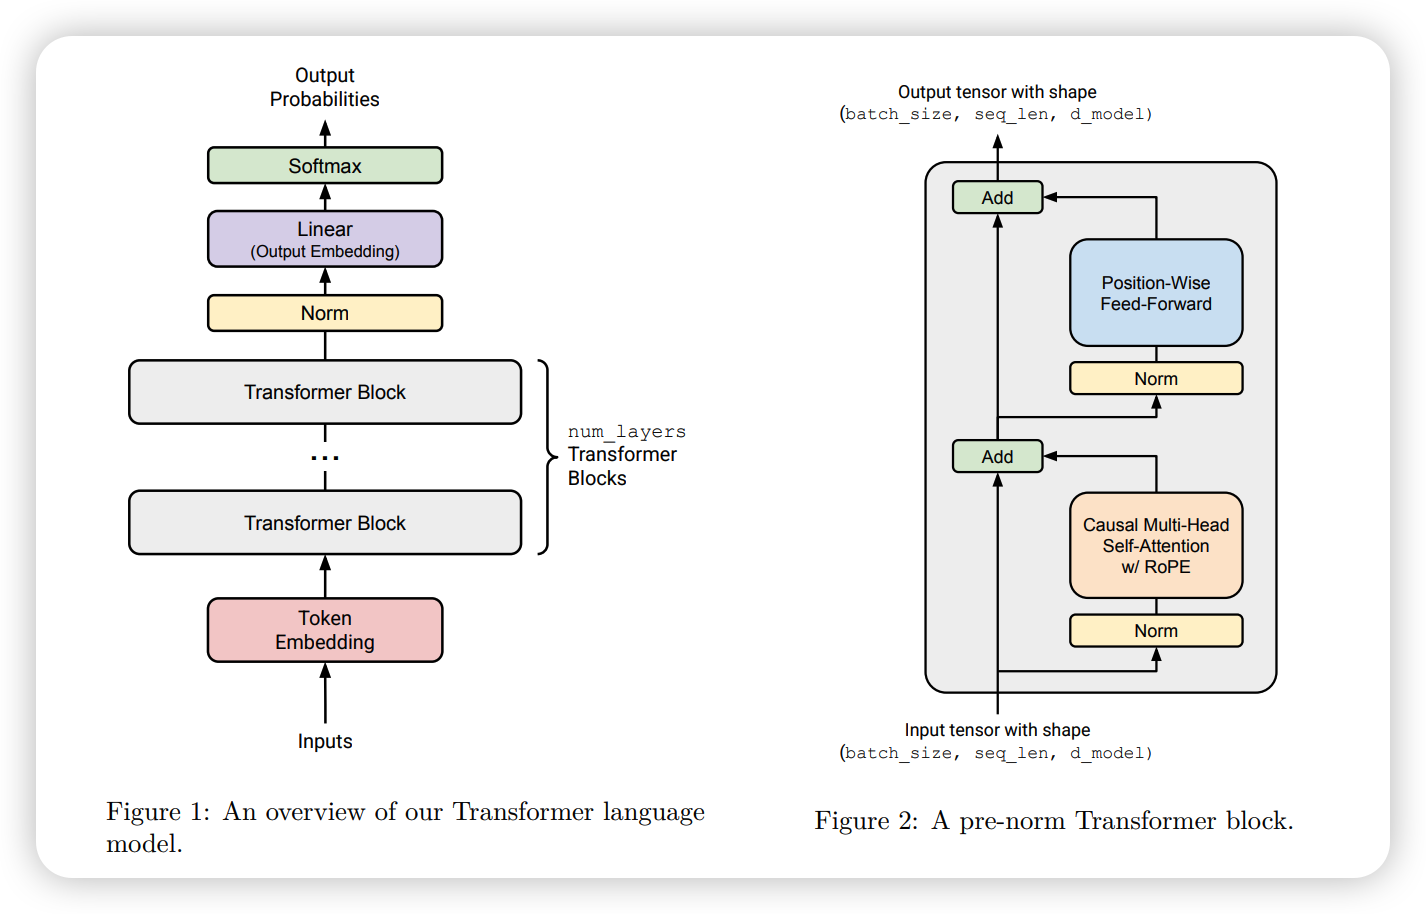

### 3.1.1 Token Embeddings


在第一步中，Transformer 将（批处理的）标记 ID 序列嵌入到包含标记身份信息的向量序列中（图 1 中的红色块）。
更具体地说，给定一系列 token ID，Transformer 语言模型使用 token 嵌入层来生成一系列向量。每个嵌入层接收一个形状为(batch_size, sequence_length)的整数张量，并生成一个形状为(batch_size, sequence_length, d_model)的向量序列。


文本-token-向量化

### 3.1.2 Pre-norm Transformer Block

嵌入后，激活值由多个结构相同的神经网络层进行处理。一个标准的仅解码器 Transformer 语言模型由 num_layers 个相同的层组成（通常称为 Transformer“模块”）。每个 Transformer 模块接收形状为(batch_size, sequence_length, d_model)的输入，并返回形状为(batch_size, sequence_length, d_model)的输出。每个模块通过自注意力机制聚合序列信息，并通过前馈层进行非线性转换。

## 3.2 Output Normalization and Embedding

经过 num_layers 个 Transformer 模块后，我们将最终激活值转换为词汇表上的分布。

我们将实现“预范数”Transformer 模块（详见§3.5），该模块额外需要在使用最终 Transformer 模块后进行层归一化（详见下文），以确保其输出被适当缩放。

在此归一化之后，我们将使用一个标准的线性变换来将 Transformer 模块的输出转换为预测的下一个 token 的 logits（例如，参见 Radford 等人[2018]方程 2）。

## 3.3 Remark: Batching, Einsum and Efficient Computation

Transformer中的批量计算与Einsum记号
核心概念：批量计算的重要性
在Transformer中，我们需要对许多"类批量"的输入执行相同的计算操作：

三种主要的批量计算场景
批次元素：对批次中的每个元素应用相同的Transformer前向操作
序列长度：位置相关操作（如RMSNorm和前馈网络）对序列的每个位置执行相同计算
注意力头：多头注意力机制中，注意力操作在多个头之间进行批量处理
PyTorch的批量操作优势
自动批量处理
PyTorch操作可以处理张量开头的额外"类批量"维度
自动在这些维度上广播操作，充分利用GPU效率
实际例子
传统方法的问题
使用 view、reshape、transpose 等操作组织张量时：

代码难以阅读
张量形状变化难以追踪
容易出错
Einsum记号的解决方案
推荐工具
初学者：使用 einops 库
进阶用户：使用更通用的 einx 库